In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
import math
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import colors
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy
from scipy.spatial.distance import pdist, squareform
# from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import sys

sys.path.append('../../')
from data_utils import *

sys.path.append('../../../DeLASE')
from delase import *
from utils import numpy_torch_conversion
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

plt.style.use('../../sci_style.py')

# Load Data

In [3]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [4]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [5]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [6]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [7]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]

In [8]:
class PCA:
    def __init__(self, n_components=None, use_torch=False, device='cpu', dtype='torch.DoubleTensor'):
        self.n_components = n_components
        self.use_torch = use_torch
        self.device = device
        self.dtype = dtype
        
    def compute_multidim_mean(self, data):
        return data.mean(axis=tuple(np.arange(0, len(data.shape)-1)))
    
    def fit(self, data):
        data = numpy_torch_conversion(data, self.use_torch, self.device, self.dtype)   
        data_centered = data - self.compute_multidim_mean(data)
        if self.use_torch:
            U, S, Vh = torch.linalg.svd(data_centered, full_matrices=False)
        else:
            U, S, Vh = np.linalg.svd(data_centered, full_matrices=False)
        self.U = U.cpu().numpy()
        self.S = S.cpu().numpy()
        self.V = Vh.cpu().numpy().T
    
    def transform(self, data):
        data = numpy_torch_conversion(data, self.use_torch, self.device, self.dtype)
        data_centered = data - self.compute_multidim_mean(data)
        return (data_centered) @ self.V[:, :self.n_components]

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [9]:
leadup = 2000
post = 2000
p = 10
# leadup = 500
# post = 1500

In [10]:
areas = ['vlPFC', 'FEF', '7b', 'CPB']

In [11]:
num_wake_samples = np.sum(tone_on <= session_info['drugStart'][0])
num_anesthesia_samples = np.sum(np.logical_and(tone_on > eyes_close, tone_on < session_info['drugEnd'][1]))
random_times = np.sort(np.random.uniform(0, session_info['drugStart'][0], size=(num_wake_samples,)))
random_times = np.hstack([random_times, np.sort(np.random.uniform(eyes_close, session_info['drugStart'][1], size=(num_anesthesia_samples,)))])

In [12]:
lfp_traj_wake = {}
lfp_traj_anesthesia = {}

for i, area in tqdm(enumerate(areas), total=len(areas)):
    
    lfp_traj_wake[area] = {}
    lfp_traj_anesthesia[area] = {}

    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]
    
    for time_locs, time_loc_array in [('tone', tone_on), ('random', random_times)]:
    
        lfp_tone_wake = []
        lfp_tone_anesthesia = []
        num_wake = 0
        num_anesthesia = 0
        for t in time_loc_array:
            if t < session_info['drugStart'][0]:
                t = int(t/dt)
                lfp_tone_wake.append(embed_signal(lfp[t - leadup -p + 1:t + post, unit_indices], p, use_torch=False))
                num_wake += 1
            elif t > eyes_close and t < session_info['drugEnd'][1]:
                t = int(t/dt)
                lfp_tone_anesthesia.append(embed_signal(lfp[t - leadup - p + 1:t + post, unit_indices], p, use_torch=False))
                num_anesthesia += 1
        lfp_tone_wake = np.array(lfp_tone_wake)
        lfp_tone_anesthesia = np.array(lfp_tone_anesthesia)
        
        lfp_traj_wake[area][time_locs] = lfp_tone_wake
        lfp_traj_anesthesia[area][time_locs] = lfp_tone_anesthesia

  0%|          | 0/4 [00:00<?, ?it/s]

# PCA Trajectories

In [26]:
iterator = tqdm(total=8)
pca_traj_wake = {}
pca_traj_anesthesia = {}
for area in areas:
    pca_traj_wake[area] = {}
    pca_traj_anesthesia[area] = {}
    for time_loc_type in ['tone', 'random']:
        pca_traj_wake[area][time_loc_type] = {}
        pca_traj_anesthesia[area][time_loc_type] = {}
        
        lfp_tone_wake = lfp_traj_wake[area][time_loc_type]
        lfp_tone_anesthesia = lfp_traj_anesthesia[area][time_loc_type]
        
        lfp_tone_wake_mean = lfp_tone_wake.mean(axis=0)
        lfp_tone_wake_se = lfp_tone_wake.mean(axis=0)/np.sqrt(lfp_tone_wake.shape[0])
        lfp_tone_anesthesia_mean = lfp_tone_anesthesia.mean(axis=0)
        lfp_tone_anesthesia_se = lfp_tone_anesthesia.mean(axis=0)/np.sqrt(lfp_tone_anesthesia.shape[0])

        embed_method = 'PCA'
        if embed_method == 'PCA':
            manifold_embed = PCA(n_components=3)
        elif embed_method == 'Isomap':
            manifold_embed = Isomap(n_components=3, n_neighbors=5)
        elif embed_method == 'TPHATE':
            manifold_embed = tphate.TPHATE(n_components=3, t=5, decay=5)

        stack = np.vstack([lfp_tone_wake_mean, lfp_tone_anesthesia_mean])
        manifold_embed.fit(stack)

        pca_traj_wake[area][time_loc_type]['pca_mean_traj'] = {}
        pca_traj_wake[area][time_loc_type]['pca_se_traj'] = {}
        pca_traj_anesthesia[area][time_loc_type]['pca_mean_traj'] = {}
        pca_traj_anesthesia[area][time_loc_type]['pca_se_traj'] = {}
        pca_traj_wake[area][time_loc_type]['pca_mean_traj']['shared'] = manifold_embed.transform(lfp_tone_wake_mean)
        pca_traj_anesthesia[area][time_loc_type]['pca_mean_traj']['shared'] = manifold_embed.transform(lfp_tone_anesthesia_mean)
        pca_traj_wake[area][time_loc_type]['pca_se_traj']['shared'] = manifold_embed.transform(lfp_tone_wake_se)
        pca_traj_anesthesia[area][time_loc_type]['pca_se_traj']['shared'] = manifold_embed.transform(lfp_tone_anesthesia_se)

        manifold_embed.fit(lfp_tone_wake_mean)
        pca_traj_wake[area][time_loc_type]['pca_mean_traj']['split'] = manifold_embed.transform(lfp_tone_wake_mean)
        manifold_embed.fit(lfp_tone_anesthesia_mean)
        pca_traj_anesthesia[area][time_loc_type]['pca_mean_traj']['split'] = manifold_embed.transform(lfp_tone_anesthesia_mean)
        
        iterator.update()
iterator.close()

  0%|          | 0/8 [00:00<?, ?it/s]

In [27]:
basis = 'shared'
# time_locs = 'tone'
time_locs = 'random'

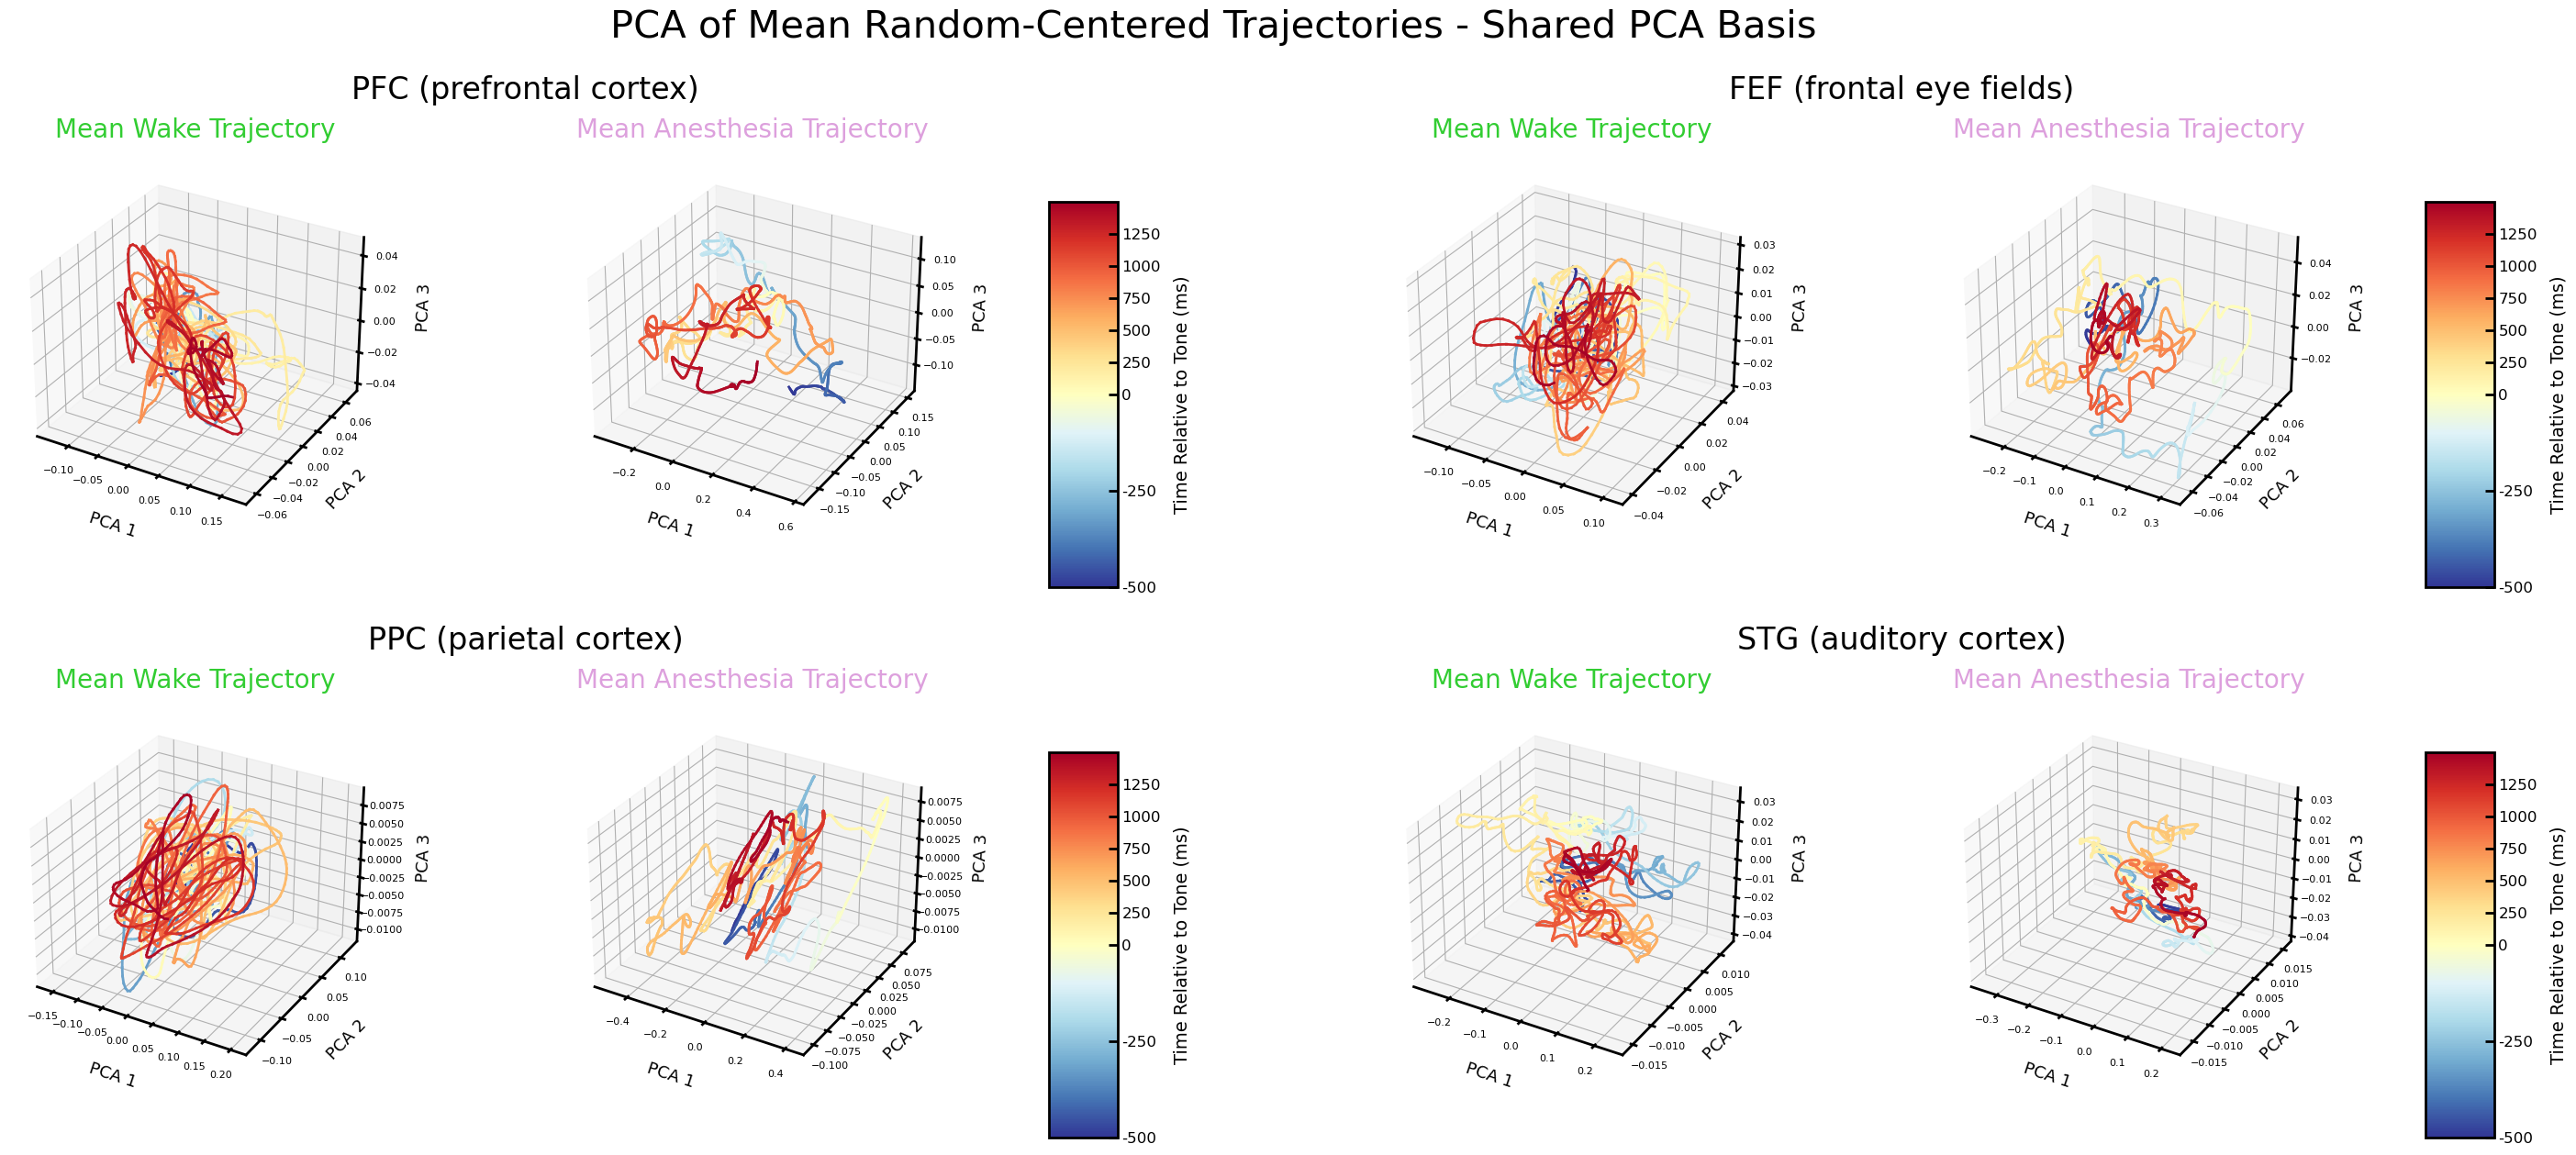

In [28]:
area_colors = {
    'CPB': 'lightsteelblue', 
    '7b': 'slategray',
    'FEF': 'skyblue',
    'vlPFC': 'C0',
    'all': 'purple'
}

area_labels = {
    'CPB': 'STG (auditory cortex)',
    '7b': 'PPC (parietal cortex)',
    'FEF': 'FEF (frontal eye fields)',
    'vlPFC': 'PFC (prefrontal cortex)'
}

fig = plt.figure(figsize=(30, 12))
fig.suptitle(f"PCA of Mean {time_locs.capitalize()}-Centered Trajectories - {basis.capitalize()} PCA Basis", fontsize=30, y=1.05)
# fig.subplots_adjust(top=0.85)
subfigs = fig.subfigures(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
for i, area in enumerate(areas):
    
    fig = subfigs[int(i/2)][i%2]
    fig.set_facecolor('none')
    
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=leadup, vmax=leadup + post)
    cmap = plt.cm.get_cmap('RdYlBu_r')
    
    axs = fig.subplots(1, 2, subplot_kw=dict(projection="3d"))
    fig.suptitle(f"{area_labels[area]}")
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    
    axis_label_fontsize = 13

    ax = axs[0]
#     ax.remove()
#     ax = fig.add_subplot(1, 2, 1,projection='3d')
    X = pca_traj_wake[area][time_locs]['pca_mean_traj'][basis]
    for i in range(X.shape[0] - 1):
        ax.plot([X[i, 0], X[i+1, 0]], [X[i, 1], X[i+1, 1]], [X[i, 2], X[i+1, 2]], c=cmap(norm(i)))
    ax.set_xlabel('PCA 1', fontsize=axis_label_fontsize)
    ax.set_ylabel('PCA 2', fontsize=axis_label_fontsize)
    ax.set_zlabel('PCA 3', fontsize=axis_label_fontsize)
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])
    ax.set_title("Mean Wake Trajectory", fontsize=20, c='limegreen')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    ## ANESTHESIA !!!!!
    # X = manifold_embed.fit_transform(lfp_tone_anesthesia.mean(axis=0))
#     if embed_method == 'TPHATE':
#         manifold_embed = tphate.TPHATE(n_components=3, t=5, decay=5)
    # X = manifold_embed.fit_transform(lfp_tone_anesthesia[0])

    ax = axs[1]
#     ax.remove()
#     ax = fig.add_subplot(1, 2, 2,projection='3d')
    X = X = pca_traj_anesthesia[area][time_locs]['pca_mean_traj'][basis]
    for i in range(X.shape[0] - 1):
        ax.plot([X[i, 0], X[i+1, 0]], [X[i, 1], X[i+1, 1]], [X[i, 2], X[i+1, 2]], c=cmap(norm(i)))
    ax.set_xlabel('PCA 1', fontsize=axis_label_fontsize)
    ax.set_ylabel('PCA 2', fontsize=axis_label_fontsize)
    ax.set_zlabel('PCA 3', fontsize=axis_label_fontsize) 
    ax.set_title("Mean Anesthesia Trajectory", fontsize=20, c='plum')
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # plt.suptitle(f'{embed_method} of Tone Event-Related Potentials in {area_labels[area]}', fontsize=18)
#     plt.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.88, 0.05, 0.05, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(0, leadup + post, 250), label='Time Relative to Tone (ms)')
    cbar.ax.set_yticklabels(np.arange(-leadup, post, 250), fontsize=12)
    cbar.set_label(label='Time Relative to Tone (ms)', fontsize=14)
    

# State Space Binning

In [13]:
area = 'vlPFC'
time_loc_type = 'random'
num_dims = 3
basis = 'shared'
mean_traj = False
bounds = 'shared'

In [14]:
lfp_tone_wake = lfp_traj_wake[area][time_loc_type]
lfp_tone_anesthesia = lfp_traj_anesthesia[area][time_loc_type]

lfp_tone_wake_mean = lfp_tone_wake.mean(axis=0)
# lfp_tone_wake_se = lfp_tone_wake.mean(axis=0)/np.sqrt(lfp_tone_wake.shape[0])
lfp_tone_anesthesia_mean = lfp_tone_anesthesia.mean(axis=0)
# lfp_tone_anesthesia_se = lfp_tone_anesthesia.mean(axis=0)/np.sqrt(lfp_tone_anesthesia.shape[0])

embed_method = 'PCA'
if embed_method == 'PCA':
    manifold_embed = PCA(n_components=3, use_torch=True, device='cpu')
elif embed_method == 'Isomap':
    manifold_embed = Isomap(n_components=3, n_neighbors=5)
elif embed_method == 'TPHATE':
    manifold_embed = tphate.TPHATE(n_components=3, t=5, decay=5)

stack = np.vstack([lfp_tone_wake_mean, lfp_tone_anesthesia_mean])
manifold_embed.fit(stack)

if mean_traj:
    wake = manifold_embed.transform(lfp_tone_wake_mean).cpu().numpy()
    anesthesia = manifold_embed.transform(lfp_tone_anesthesia_mean).cpu().numpy()
    
    if bounds == 'shared':
        min_vals = np.vstack([wake.min(axis=0)[:num_dims], anesthesia.min(axis=0)[:num_dims]]).min(axis=0)
        max_vals = np.vstack([wake.max(axis=0)[:num_dims], anesthesia.max(axis=0)[:num_dims]]).max(axis=0)
    else:
        wake_min_vals = wake.min(axis=0)[:num_dims]
        wake_max_vals = wake.max(axis=0)[:num_dims]
        anesthesia_min_vals = anesthesia.min(axis=0)[:num_dims]
        anesthesia_max_vals = anesthesia.max(axis=0)[:num_dims]

else:
    wake_all = manifold_embed.transform(lfp_tone_wake).cpu().numpy()
    anesthesia_all = manifold_embed.transform(lfp_tone_anesthesia).cpu().numpy()

    if bounds == 'shared':
        min_vals = np.vstack([wake_all.min(axis=(0, 1))[:num_dims], anesthesia_all.min(axis=(0, 1))[:num_dims]]).min(axis=0)
        max_vals = np.vstack([wake_all.max(axis=(0, 1))[:num_dims], anesthesia_all.max(axis=(0, 1))[:num_dims]]).max(axis=0)
    else:
        wake_min_vals = wake_all.min(axis=(0, 1))[:num_dims]
        wake_max_vals = wake_all.max(axis=(0, 1))[:num_dims]
        anethesia_min_vals = anesthesia_all.min(axis=(0, 1))[:num_dims]
        anethesia_max_vals = anesthesia_all.max(axis=(0, 1))[:num_dims]

    wake = wake_all[40]
    anesthesia = anesthesia_all[40]

In [15]:
num_bins = 8

In [16]:
if bounds == 'shared':
    bin_bounds = [np.linspace(min_vals[i], max_vals[i], num_bins + 1) for i in range(num_dims)]
    bin_bounds_torch = [torch.from_numpy(bound) for bound in bin_bounds]
    
    wake_bin_bounds=bin_bounds
    wake_bin_bounds_torch=bin_bounds_torch
    anesthesia_bin_bounds=bin_bounds
    anesthesia_bin_bounds_torch=bin_bounds_torch
else:
    wake_bin_bounds = [np.linspace(wake_min_vals[i], wake_max_vals[i], num_bins + 1) for i in range(num_dims)]
    wake_bin_bounds_torch = [torch.from_numpy(bound) for bound in wake_bin_bounds]
    anesthesia_bin_bounds = [np.linspace(anesthesia_min_vals[i], anesthesia_max_vals[i], num_bins + 1) for i in range(num_dims)]
    anesthesia_bin_bounds_torch = [torch.from_numpy(bound) for bound in anesthesia_bin_bounds]
    

In [17]:
hist_w = torch.histogramdd(torch.from_numpy(wake[:, :num_dims]), tuple(wake_bin_bounds_torch))
hist_a = torch.histogramdd(torch.from_numpy(anesthesia[:, :num_dims]), tuple(anesthesia_bin_bounds_torch))

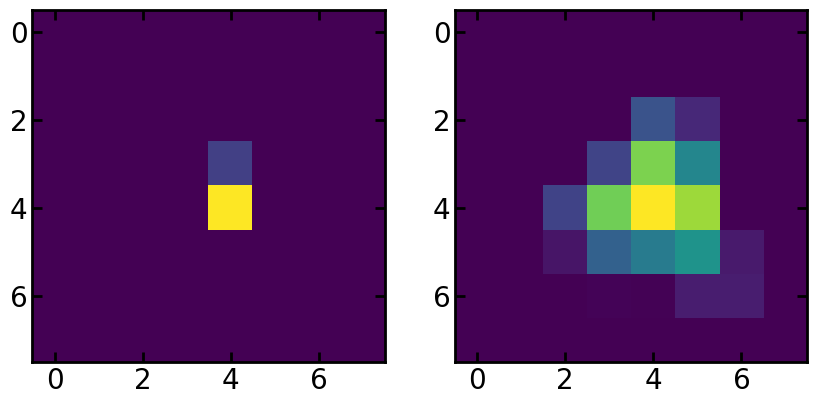

In [18]:
if num_dims == 3:
    plt.subplot(1, 2, 1)
    plt.imshow(hist_w.hist[:, :, int(num_bins/2)])
    plt.subplot(1, 2, 2)
    plt.imshow(hist_a.hist[:, :, int(num_bins/2)])
else:
    plt.subplot(1, 2, 1)
    plt.imshow(hist_w.hist)
    plt.subplot(1, 2, 2)
    plt.imshow(hist_a.hist)
plt.show()

In [19]:
def get_bin_nums(pt, bins):
    bin_num_ind = np.zeros(len(pt))
    for i in range(len(pt)):
        bool_vec = pt[i] <= bins[i]
        if bool_vec.sum() == 0:
            bin_num_ind[i] = len(bool_vec) - 1
        elif bool_vec.sum() == len(bool_vec):
            bin_num_ind[i] = 0
        else:
            bin_num_ind[i] = np.argmax(bool_vec) - 1
    return bin_num_ind

def get_bin_sequence(traj, bins):
    bin_sequence = np.zeros(traj.shape, dtype=int)
    for i in range(traj.shape[0]):
        bin_sequence[i] = get_bin_nums(traj[i], bins)
    
    return bin_sequence

In [20]:
time_vals = np.arange(-leadup, post)

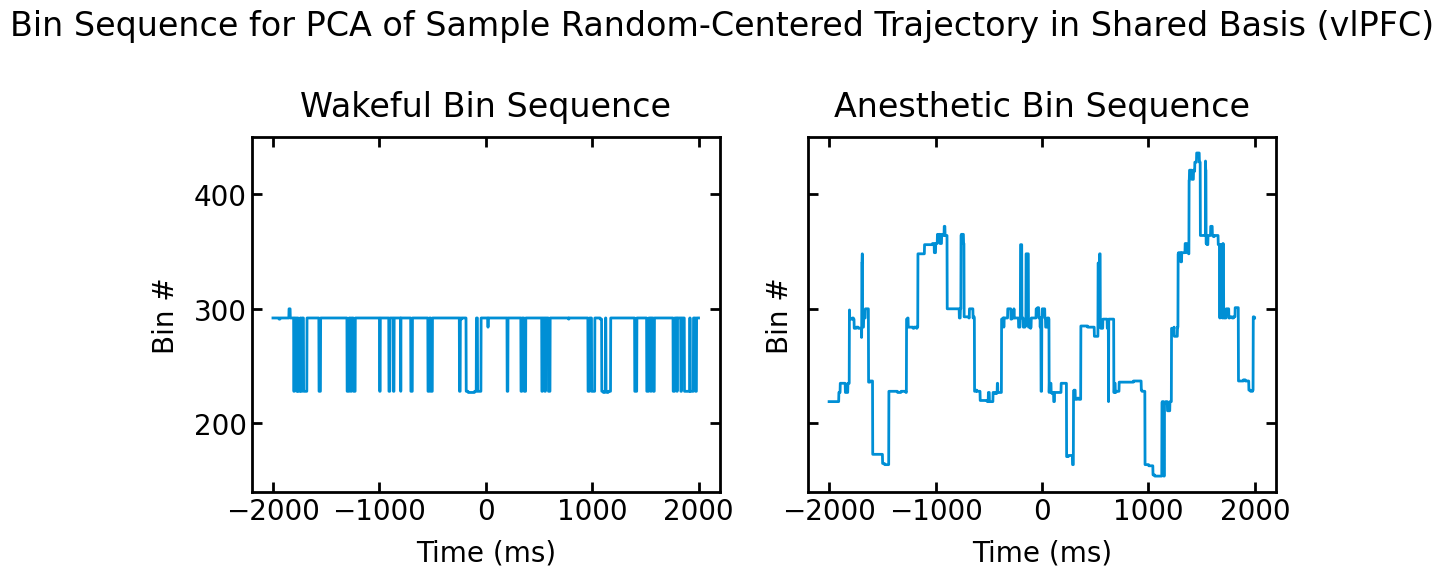

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax = axs[0]
if bounds == 'shared':
    bin_sequence = get_bin_sequence(wake[:, :num_dims], bin_bounds)
else:
    bin_sequence = get_bin_sequence(wake[:, :num_dims], wake_bin_bounds)
bin_sequence = np.array([np.ravel_multi_index(bin_sequence[i], [num_bins]*num_dims) for i in range(len(bin_sequence))])
ax.set_title('Wakeful Bin Sequence')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Bin #')
ax.plot(time_vals, bin_sequence)

ax = axs[1]
if bounds == 'shared':
    bin_sequence = get_bin_sequence(anesthesia[:, :num_dims], bin_bounds)
else:
    bin_sequence = get_bin_sequence(anesthesia[:, :num_dims], anesthesia_bin_bounds)
bin_sequence = np.array([np.ravel_multi_index(bin_sequence[i], [num_bins]*num_dims) for i in range(len(bin_sequence))])
ax.set_title('Anesthetic Bin Sequence')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Bin #')
ax.plot(time_vals, bin_sequence)
fig.suptitle(('Bin Sequence for PCA of '  + ('Mean' if mean_traj else 'Sample') + f' {time_loc_type.capitalize()}-Centered Trajectory') + f" in {basis.capitalize()} Basis ({area})")
plt.tight_layout()
plt.show()

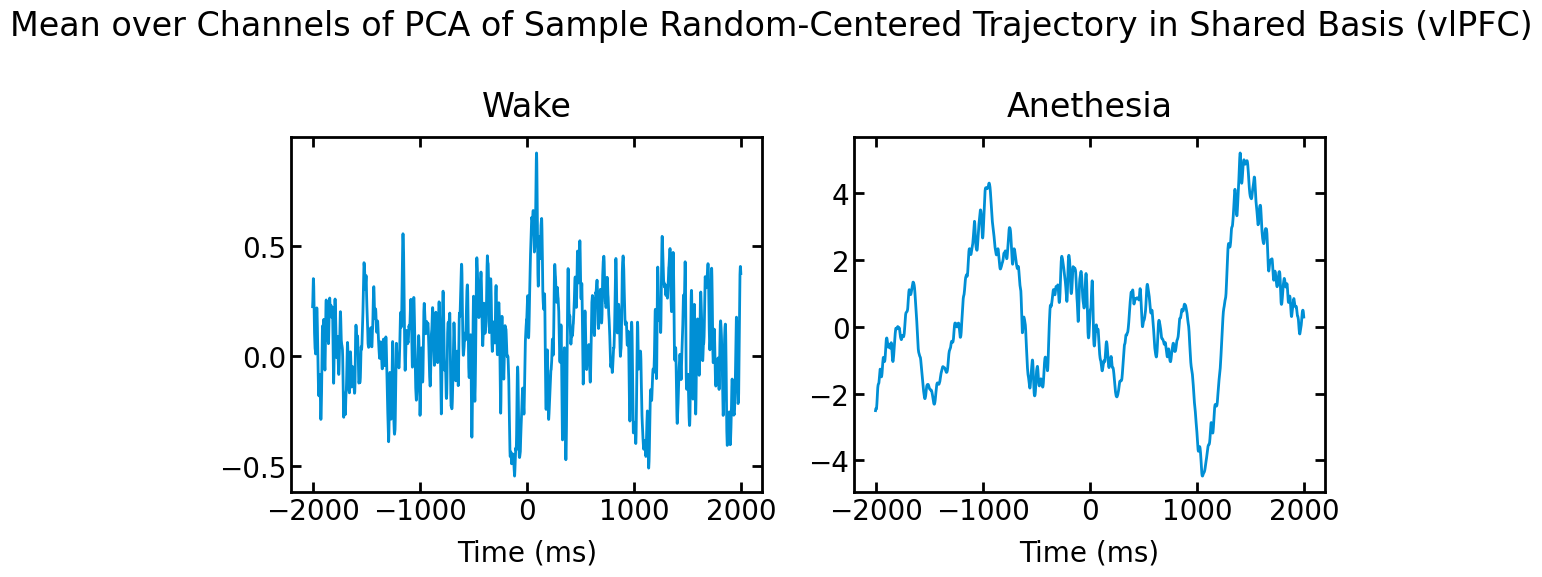

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(('Mean over Channels of PCA of '  + ('Mean' if mean_traj else 'Sample') + f' {time_loc_type.capitalize()}-Centered Trajectory') + f" in {basis.capitalize()} Basis ({area})")
axs[0].plot(time_vals, wake.mean(1))
axs[0].set_title('Wake')
axs[0].set_xlabel('Time (ms)')

axs[1].set_title('Anethesia')
axs[1].set_xlabel('Time (ms)')
axs[1].plot(time_vals, anesthesia.mean(1))

plt.tight_layout()
plt.show()

## Dwell Times

In [23]:
def compute_sequence_lengths(arr):
    
    # Initialize variables
    current_num = arr[0]
    current_length = 1
    lengths = []
    
    # Iterate through array
    for i in range(1, len(arr)):
        if arr[i] == current_num:
            current_length += 1
        else:
            lengths.append(current_length)
            current_num = arr[i]
            current_length = 1
    
    # Append the final length to the list
    lengths.append(current_length)
    
    return lengths


In [24]:
seq_lengths_full = []
iterator = tqdm(total=wake_all.shape[0] + anesthesia_all.shape[0])
for trajs, bounds in [(wake_all, wake_bin_bounds), (anesthesia_all, anesthesia_bin_bounds)]:
    seq_lengths_all = []
    for ind in range(trajs.shape[0]):
        traj = trajs[ind]
        bin_sequence = get_bin_sequence(traj[:, :num_dims], bounds)
        if np.sum(bin_sequence == -1) > 0:
            raise ValueError
        bin_sequence = np.array([np.ravel_multi_index(bin_sequence[i], [num_bins]*num_dims) for i in range(len(bin_sequence))])
        seq_lengths = np.array(compute_sequence_lengths(bin_sequence))
        seq_lengths_all.extend(seq_lengths)
        iterator.update()
    seq_lengths_full.append(seq_lengths_all)
iterator.close()

  0%|          | 0/540 [00:00<?, ?it/s]

In [25]:
num_hist_bins = 50

In [26]:
seq_length_wake = np.array(seq_lengths_full[0])
seq_length_anesthesia = np.array(seq_lengths_full[1])

In [27]:
bins=np.linspace(np.min([seq_length_wake.min(), seq_length_anesthesia.min()]), np.max([seq_length_wake.max(), seq_length_anesthesia.max()]), num_hist_bins)

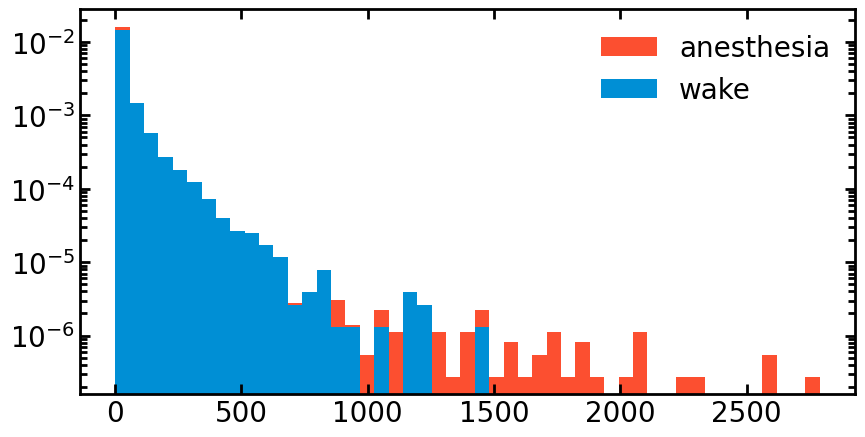

In [28]:
plt.hist(seq_length_anesthesia, bins=bins, density=True, color='C1', label='anesthesia', log=True)
plt.hist(seq_length_wake, bins=bins, density=True, color='C0', label='wake', log=True)
plt.legend()
plt.show()